# A toy 21-cm Cosmology Emulator

We will approximate the sky-averaged 21-cm signal as a Gaussian absorption feature with three parameters: an amplitude $A$, a central redshift $z_c$, and a width $\sigma$. We will then build a simple emulator with a neural network to predict the signal temperature given a set of parameters and redshift input.

We will start by loading the relevant modules.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tqdm import tqdm
import time

## Generating training and test data

We need a set of example signals to train our neural network with and a set to test the accuracy of the emulator.

We are modelling the signal as a Gaussian so we need to define a function to generate gaussian signals. We will also need a function to generate a set of parameters for the signals and so need to define a prior over which to train our neural network emulator. When defining our prior we should bear in mind the prior we want to explore in our inference since outside the range of the prior the emulator will not be reliable.

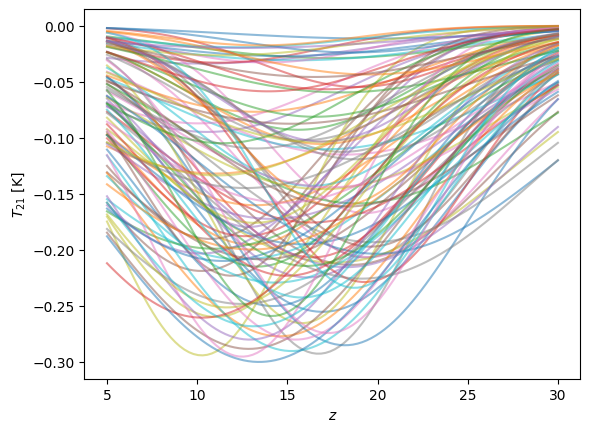

In [2]:
def gaussian(parameters):
    """a simple Gaussian function"""
    return -parameters[0] * \
        np.exp(-0.5*(z - parameters[1])**2/
               parameters[2]**2)

def prior(n):
    """a simple prior"""
    theta = np.ones((n, 3))
    theta[:, 0] = np.random.uniform(0.01, 0.3, n) # amplitude
    theta[:, 1] = np.random.uniform(10, 20, n) # mean
    theta[:, 2] = np.random.uniform(5, 10, n) # width
    return theta

z = np.linspace(5, 30, 100)[::-1]
n = 15000
parameters = prior(n)
signals = np.array([gaussian(parameters[i]) for i in range(n)])
[plt.plot(z, signals[i], alpha=0.5) for i in range(100)]
plt.xlabel(r'$z$')
plt.ylabel(r'$T_{21}$ [K]')
plt.savefig('gaussian-signals.png', dpi=300, bbox_inches='tight')


Once we have generated a large sample, here 15000, of signals we need to split the signals into a training and test set. Then we need to normalise the data so that the inputs and outputs of the network are all of order one. This makes the problem easier to fit.

For our problem we also want to tile the inputs with redshift so that we can keep the network small and predict a single temperature for a single redhsift input. Our input training data for N signals and K redshifts will look something like

```
[[A1, zc1, sigma1, z1],
[A1, zc1, sigma1, z2],
[A1, zc1, sigma1, z3],
...
[A1, zc1, sigma1, zK],
[A2, zc2, sigma2, z1],
[A2, zc2, sigma2, z2],
[A2, zc2, sigma2, z3],
...
[A2, zc2, sigma2, zK],
...
[AN, zcN, sigmaN, z1],
[AN, zcN, sigmaN, z2],
[AN, zcN, sigmaN, z3],
...
[AN, zcN, sigmaN, zK]]
```

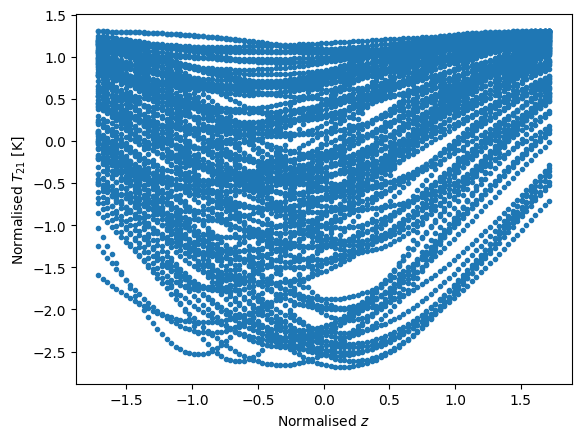

In [3]:
# split the data
idx = random.sample(range(n), int(n*0.8))
train_params_pretile = parameters[idx]
train_signals_pretile = signals[idx]
test_params_pretile = np.delete(parameters, idx, axis=0)
test_signals_pretile = np.delete(signals, idx, axis=0)

# tile the data
ztile = np.tile(z, len(train_params_pretile)).reshape(len(z)*len(train_params_pretile))
train_params_tile = np.tile(train_params_pretile, len(z)).reshape(len(z)*len(train_params_pretile), 3)
train_signals_tile = np.concatenate(train_signals_pretile).T
train_params_tile = np.hstack((train_params_tile, ztile.reshape(-1, 1)))

ztile = np.tile(z, len(test_params_pretile)).reshape(len(z)*len(test_params_pretile))
test_params_tile = np.tile(test_params_pretile, len(z)).reshape(len(z)*len(test_params_pretile), 3)
test_signals_tile = np.concatenate(test_signals_pretile).T
test_params_tile = np.hstack((test_params_tile, ztile.reshape(-1, 1)))

norm_param_means = np.mean(train_params_tile, axis=0)
norm_param_stds = np.std(train_params_tile, axis=0)
norm_signal_means = np.mean(train_signals_tile, axis=0)
norm_signal_stds = np.std(train_signals_tile, axis=0)
# normalise the data
train_params = (train_params_tile - norm_param_means) / norm_param_stds
train_signals = (train_signals_tile - norm_signal_means) / norm_signal_stds
test_params = (test_params_tile - norm_param_means) / norm_param_stds
test_signals = (test_signals_tile - norm_signal_means) / norm_signal_stds

plt.scatter(train_params[:10000, -1], train_signals[:10000], marker='.')
plt.xlabel(r'Normalised $z$')
plt.ylabel(r'Normalised $T_{21}$ [K]')
plt.savefig('gaussian-normalised-signals.png', dpi=300, bbox_inches='tight')

## Building the neural network and training

Now we can set up and train the neural network. We have to make some choice about the architecture of our network and the activation functions. Here we have 4 inputs (A, zc, sigma, z) and one output (T(z)) so we have a very simple network with only four hidden layers of 8 nodes each. We make the network a fully connected network and use sigmoid activation funcitons on the input layer and hidden layers. We have a linear activation function on the output node.

We use the adam optimizer (a fairly standard choice) to optimize the weights of the network connections. Adam is a stochastic gradient descent algorithm that uses moments to speed up the optimization and has an adaptive learning rate (step size to take at each iteration). We use a mean squared error loss function and run early stopping on the test data to prevent over fitting.

In [4]:
# callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# neural network architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, activation='sigmoid'),
  tf.keras.layers.Dense(8, activation='sigmoid'),
  tf.keras.layers.Dense(8, activation='sigmoid'),
  tf.keras.layers.Dense(8, activation='sigmoid'),
  tf.keras.layers.Dense(8, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='linear'),
])

# building the model with the adam optimizer and mean squared error loss function
model.compile(optimizer='adam',
              loss='mse',)

# training the model
model.fit(train_params, train_signals, epochs=200, batch_size=250,
          callbacks=[callback], validation_data=(test_params, test_signals))

# evaluating the loss on the test data
model.evaluate(test_params, test_signals)

Epoch 1/200
4800/4800 [==============================] - 3s 594us/step - loss: 0.1310 - val_loss: 0.0089
Epoch 2/200
4800/4800 [==============================] - 3s 538us/step - loss: 0.0080 - val_loss: 0.0069
Epoch 3/200
4800/4800 [==============================] - 3s 582us/step - loss: 0.0068 - val_loss: 0.0064
Epoch 4/200
4800/4800 [==============================] - 3s 558us/step - loss: 0.0066 - val_loss: 0.0063
Epoch 5/200
4800/4800 [==============================] - 3s 562us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 6/200
4800/4800 [==============================] - 3s 529us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 7/200
4800/4800 [==============================] - 3s 551us/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/200
4800/4800 [==============================] - 3s 528us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 9/200
4800/4800 [==============================] - 3s 531us/step - loss: 0.0063 - val_loss: 0.0060
Epoch 10/200
4800/4800 [==============================]

2.0783378204214387e-05

## Assessing the accuracy of our emulator

Here we demonstrate how to generate signals with the neural network emulator and assess the accuracy of the network when emulating the test data.

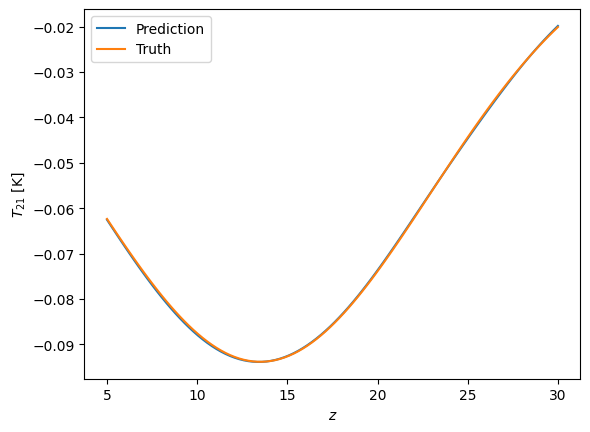

In [5]:
def prediction(params):
    """
    This function takes in a set of unormalized parameters (A, zc, sigma) 
    and returns a predicted signal in the unormalized space.
    """
    params = np.tile(params, len(z)).reshape(len(z), 3)
    params = np.hstack((params, z.reshape(-1, 1)))
    params = (params - norm_param_means) / norm_param_stds
    pred = model.predict(params, verbose=0)
    return pred*norm_signal_stds + norm_signal_means

pred = prediction(test_params_pretile[100])
plt.plot(z, pred, label='Prediction')
plt.plot(z, test_signals_pretile[100], label='Truth')
plt.xlabel(r'$z$')
plt.ylabel(r'$T_{21}$ [K]')
plt.legend()
plt.savefig('gaussian-prediction-example.png', dpi=300, bbox_inches='tight')

We can assess the overall accuracy of the network with the percentage error metric.

$\sigma = 100 \frac{\frac{1}{N}\sum_i |T_{\text{true}}(z_i) - T_{\text{emulated}}(z_i)|}{\mathrm{Max}(|T_{\text{true}}(z)|)}$

In [6]:
error = []
for i in tqdm(range(len(test_params_pretile))):
    pred = prediction(test_params_pretile[i])
    error.append(100*np.mean(np.abs(pred - test_signals_pretile[i]))
                 /np.max(np.abs(test_signals_pretile[i])))
error = np.array(error)


100%|██████████| 3000/3000 [01:27<00:00, 34.09it/s]


Mean error:  32.22597489940441  %
95th Percentile:  41.8160298870163  %


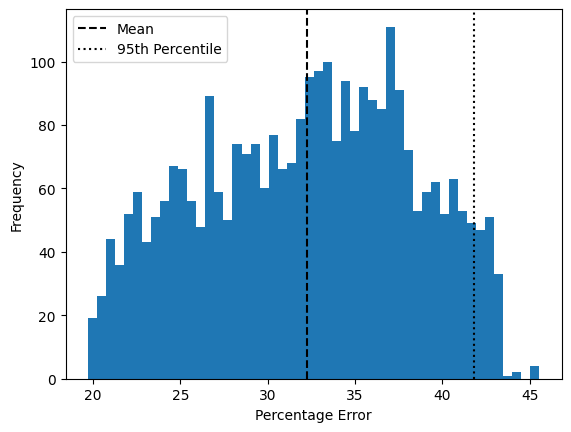

In [7]:

print('Mean error: ', np.mean(error), ' %')
print('95th Percentile: ', np.quantile(error, 0.95), ' %')

plt.hist(error, bins=50)
plt.axvline(np.mean(error), label='Mean', ls='--', c='k')
plt.axvline(np.quantile(error, 0.95),
            label='95th Percentile', ls=':', c='k')
plt.legend()
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.savefig('errors.png', dpi=300, bbox_inches='tight')
